### Import

In [1]:
import pandas as pd
import numpy as np

import os
from tqdm import tqdm
import json
import shutil

# image data
from PIL import Image
from glob import glob
# import cv2

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
!nvidia-smi

Wed Oct 12 08:01:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   34C    P0    38W / 300W |      0MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:06.0 Off |                  Off |
| N/A   34C    P0    64W / 300W |  31117MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

### 1. EDA

In [5]:
os.getcwd()

'/home/ncp/workspace/blocks3/Gun_code'

In [6]:
# define paths for ART, PRE train datas

ART_path = '/home/ncp/workspace/blocks1/kidneyData_windowing_mass/TRAIN/ART/'
PRE_path = '/home/ncp/workspace/blocks1/kidneyData_windowing_mass/TRAIN/PRE/'

print("ART_TRAIN N: ", len(os.listdir(ART_path)))
print("PRE_TRAIN N: ", len(os.listdir(PRE_path)))

ART_TRAIN N:  2398
PRE_TRAIN N:  2369


In [9]:
new_ART_train_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TRAIN/ART/'
new_ART_test_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TEST/ART/'
new_PRE_train_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TRAIN/PRE/'
new_PRE_test_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TEST/PRE/'


ART

In [10]:
# check len of each labels

print("ART Train : ")
print("RCC ", len(os.listdir(new_ART_train_path + 'RCC/')))
print("AML + onco ", len(os.listdir(new_ART_train_path + 'AML + onco/')))
print("----------")
print("ART Test : ")
print("RCC ", len(os.listdir(new_ART_test_path + 'RCC/')))
print("AML + onco ", len(os.listdir(new_ART_test_path + 'AML + onco/')))
print("----------")
print("PRE Train : ")
print("RCC ", len(os.listdir(new_PRE_train_path + 'RCC/')))
print("AML + onco ", len(os.listdir(new_PRE_train_path + 'AML + onco/')))
print("----------")
print("PRE Test : ")
print("RCC ", len(os.listdir(new_PRE_test_path + 'RCC/')))
print("AML + onco ", len(os.listdir(new_PRE_test_path + 'AML + onco/')))
print("----------")

ART Train : 
RCC  1091
AML + onco  1307
----------
ART Test : 
RCC  254
AML + onco  69
----------
PRE Train : 
RCC  1064
AML + onco  1305
----------
PRE Test : 
RCC  256
AML + onco  75
----------


### 3. Classification

In [11]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from keras.utils import np_utils
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers, optimizers
import tensorflow as tf
from tensorflow.keras.applications import ResNet50,VGG16,ResNet101, VGG19, DenseNet201,   MobileNetV2 # ,EfficientNetB4
from tensorflow.keras.applications import resnet, vgg16 , vgg19, densenet,  mobilenet_v2 # ,efficientnet
from tensorflow.keras import Model

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy

import PIL
import os

In [12]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [13]:
batch_size = 32
img_height = 512
img_width = 512

In [14]:
ART_train_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TRAIN/ART/'
ART_test_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TEST/ART/'
PRE_train_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TRAIN/PRE/'
PRE_test_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TEST/PRE/'

image_shape = (512, 512, 3)
N_CLASSES = 2
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', 
                                       preprocessing_function=resnet.preprocess_input,
                                       validation_split = 0.2)

test_datagen = ImageDataGenerator(dtype='float32', 
                                  preprocessing_function=resnet.preprocess_input, 
                                  rescale= 1./255.)

ART_train_generator = train_datagen.flow_from_directory(ART_train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (512, 512),
                                                   class_mode = 'categorical', 
                                                    subset = 'training')
ART_val_generator = train_datagen.flow_from_directory(ART_train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (512, 512),
                                                   class_mode = 'categorical', 
                                                    subset = 'validation')
ART_test_generator = test_datagen.flow_from_directory(ART_test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (512, 512),
                                                   class_mode = 'categorical')
                                                    

PRE_train_generator = train_datagen.flow_from_directory(PRE_train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (512, 512),
                                                   class_mode = 'categorical', 
                                                    subset = 'training')
PRE_val_generator = train_datagen.flow_from_directory(PRE_train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (512, 512),
                                                   class_mode = 'categorical', 
                                                    subset = 'validation')
PRE_test_generator = test_datagen.flow_from_directory(PRE_test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (512, 512),
                                                   class_mode = 'categorical')

Found 1919 images belonging to 2 classes.
Found 479 images belonging to 2 classes.
Found 323 images belonging to 2 classes.
Found 1896 images belonging to 2 classes.
Found 473 images belonging to 2 classes.
Found 331 images belonging to 2 classes.


### RESNET50

In [ ]:
# res_model = ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
# for layer in res_model.layers:
#     if 'conv5' not in layer.name:
#         layer.trainable = False

In [ ]:
res_model = ResNet50(include_top=False, pooling='avg', weights=None, input_shape = (image_shape))
for layer in res_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False

In [ ]:
model = Sequential()
model.add(res_model)
model.add(Dropout(0.6))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)


learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                           patience =3, 
                                           verbose =1,
                                            factor = 0.2,
                                            min_lr =0.0000001)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
# ART train
checkpointer = ModelCheckpoint(filepath='./mass_ART-ResNet50.hdf5',
                           monitor='val_loss', verbose = 1,
                           save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

history_res = model.fit(ART_train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = ART_val_generator,
                    callbacks = [checkpointer, early_stopping,learning_rate_reduction])                   

In [ ]:
result = model.evaluate(ART_test_generator)

In [ ]:
plt.plot(history_res.history['acc'], label = 'train',)
plt.plot(history_res.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
# PRE train

checkpointer = ModelCheckpoint(filepath='./cancer_PRE-ResNet50.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

history_res = model.fit(PRE_train_generator,
                    steps_per_epoch = 20,
                    epochs = 50,
                    verbose = 1,
                    validation_data = PRE_val_generator,
                    callbacks = [checkpointer, early_stopping,learning_rate_reduction])

In [ ]:
result = model.evaluate(PRE_test_generator)

In [ ]:
plt.plot(history_res.history['acc'], label = 'train',)
plt.plot(history_res.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## compare

In [ ]:
os.getcwd()

In [ ]:
path_resnet_ART = '/home/ncp/workspace/blocks3/zio_code/cancer_ART-ResNet50.hdf5'
ART_resnet = tf.keras.models.load_model(path_resnet_ART)

In [ ]:
path_resnet_PRE = '/home/ncp/workspace/blocks3/zio_code/cancer_PRE-ResNet50.hdf5'
PRE_resnet = tf.keras.models.load_model(path_resnet_PRE)

### 2. Create label - with configuration image           
run '2. Create label' section first to create label dataframes

In [ ]:
# 기존 kidney_data - ART, PRE - Test, Train imageset 을 3개의 label별 폴더로 분류

ART_train_path = '/home/ncp/workspace/blocks1/kidneyData_windowing/Train_data/ART/'
PRE_train_path = '/home/ncp/workspace/blocks1/kidneyData_windowing/Train_data/PRE/'
ART_test_path = '/home/ncp/workspace/blocks1/kidneyData_windowing/Test_data/ART/'
PRE_test_path = '/home/ncp/workspace/blocks1/kidneyData_windowing/Test_data/PRE/'

new_ART_train_path = '/home/ncp/workspace/blocks3/zio_code/kidneyData_windowing/TRAIN/ART/'
new_ART_test_path = '/home/ncp/workspace/blocks3/zio_code/kidneyData_windowing/TEST/ART/'
new_PRE_train_path = '/home/ncp/workspace/blocks3/zio_code/kidneyData_windowing/TRAIN/PRE/'
new_PRE_test_path = '/home/ncp/workspace/blocks3/zio_code/kidneyData_windowing/TEST/PRE/'

# make dir
def makedir(path): 
    if not os.path.exists(path): 
        os.mkdir(path)
        
dir = '/home/ncp/workspace/blocks3/zio_code/kidneyData_windowing/'
makedir(os.path.join(dir, "TRAIN"))
makedir(os.path.join(dir, "TEST"))

makedir(os.path.join(dir, "TRAIN", "ART"))
makedir(os.path.join(dir, "TRAIN", "ART", "RCC"))
makedir(os.path.join(dir, "TRAIN", "ART", "AML + onco"))

makedir(os.path.join(dir, "TEST", "ART"))
makedir(os.path.join(dir, "TEST", "ART", "RCC"))
makedir(os.path.join(dir, "TEST", "ART", "AML + onco"))

makedir(os.path.join(dir, "TRAIN", "PRE"))
makedir(os.path.join(dir, "TRAIN", "PRE", "RCC"))
makedir(os.path.join(dir, "TRAIN", "PRE", "AML + onco"))

makedir(os.path.join(dir, "TEST", "PRE"))
makedir(os.path.join(dir, "TEST", "PRE", "RCC"))
makedir(os.path.join(dir, "TEST", "PRE", "AML + onco"))


# create img name list
art_train_list = os.listdir(ART_train_path)
pre_train_list = os.listdir(PRE_train_path)
art_test_list = os.listdir(ART_test_path)
pre_test_list = os.listdir(PRE_test_path)


# ART train
for img in tqdm(art_train_list): 
    case_id = img[0:10]
    label = ART_train_label.loc[ART_train_label['case_id'] == case_id, 'label'].unique().tolist()
    if label == ['RCC']: 
        shutil.copy(ART_train_path + img, new_ART_train_path + 'RCC/' + img)
    if label == ['AML + onco']: 
        shutil.copy(ART_train_path + img, new_ART_train_path + 'AML + onco/' + img)

# PRE train
for img in tqdm(pre_train_list): 
    case_id = img[0:10]
    label = PRE_train_label.loc[PRE_train_label['case_id'] == case_id, 'label'].unique().tolist()
    if label == ['RCC']: 
        shutil.copy(PRE_train_path + img, new_PRE_train_path + 'RCC/' + img)
    if label == ['AML + onco']: 
        shutil.copy(PRE_train_path + img, new_PRE_train_path + 'AML + onco/' + img)
        
# ART test
for img in tqdm(art_test_list): 
    case_id = img[0:10]
    label = ART_val_label.loc[ART_val_label['case_id'] == case_id, 'label'].unique().tolist()
    if label == ['RCC']: 
        shutil.copy(ART_test_path + img, new_ART_test_path + 'RCC/' + img)
    if label == ['AML + onco']: 
        shutil.copy(ART_test_path + img, new_ART_test_path + 'AML + onco/' + img)
        
# PRE test
for img in tqdm(pre_test_list): 
    case_id = img[0:10]
    label = PRE_val_label.loc[PRE_val_label['case_id'] == case_id, 'label'].unique().tolist()
    if label == ['RCC']: 
        shutil.copy(PRE_test_path + img, new_PRE_test_path + 'RCC/' + img)
    if label == ['AML + onco']: 
        shutil.copy(PRE_test_path + img, new_PRE_test_path + 'AML + onco/' + img)

In [ ]:
# check len of each labels

print("ART Train : ")
print("RCC ", len(os.listdir(new_ART_train_path + 'RCC/')))
print("AML + onco ", len(os.listdir(new_ART_train_path + 'AML + onco/')))
print("----------")
print("ART Test : ")
print("RCC ", len(os.listdir(new_ART_test_path + 'RCC/')))
print("AML + onco ", len(os.listdir(new_ART_test_path + 'AML + onco/')))
print("----------")
print("PRE Train : ")
print("RCC ", len(os.listdir(new_PRE_train_path + 'RCC/')))
print("AML + onco ", len(os.listdir(new_PRE_train_path + 'AML + onco/')))
print("----------")
print("PRE Test : ")
print("RCC ", len(os.listdir(new_PRE_test_path + 'RCC/')))
print("AML + onco ", len(os.listdir(new_PRE_test_path + 'AML + onco/')))
print("----------")

### 3. Classification - with configuration image

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from keras.utils import np_utils
from tensorflow.keras.layers import Dense,Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers, optimizers
import tensorflow as tf
from tensorflow.keras.applications import ResNet50,VGG16,ResNet101, VGG19, DenseNet201,   MobileNetV2 # ,EfficientNetB4
from tensorflow.keras.applications import resnet, vgg16 , vgg19, densenet,  mobilenet_v2 # ,efficientnet
from tensorflow.keras import Model

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy

import PIL
import os

In [ ]:
gpus =tf.config.experimental.list_physical_devices('GPU')
if gpus: 
    # tensorflow가 첫번째 gpu만 사용하도록 제한
    try: 
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e: 
        print(e)

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
print(gpus[0])

In [ ]:
#tf.test.is_gpu_available()
#tf.test.is_built_with_cuda()
tf.test.is_built_with_gpu_support()

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
batch_size = 32
img_height = 512
img_width = 512

In [ ]:
ART_train_path = '/home/ncp/workspace/blocks3/zio_code/kidneyData_windowing/TRAIN/ART/'
ART_test_path = '/home/ncp/workspace/blocks3/zio_code/kidneyData_windowing/TEST/ART/'
PRE_train_path = '/home/ncp/workspace/blocks3/zio_code/kidneyData_windowing/TRAIN/PRE/'
PRE_test_path = '/home/ncp/workspace/blocks3/zio_code/kidneyData_windowing/TEST/PRE/'

image_shape = (512, 512, 3)
N_CLASSES = 2
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', 
                                       rescale= 1./255.,
                                       validation_split = 0.2)

test_datagen = ImageDataGenerator(dtype='float32', 
                                       rescale= 1./255.)

ART_train_generator = train_datagen.flow_from_directory(ART_train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (512, 512),
                                                   class_mode = 'categorical', 
                                                    subset = 'training')
ART_val_generator = train_datagen.flow_from_directory(ART_train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (512, 512),
                                                   class_mode = 'categorical', 
                                                    subset = 'validation')
ART_test_generator = test_datagen.flow_from_directory(ART_test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (512, 512),
                                                   class_mode = 'categorical')
                                                    

PRE_train_generator = train_datagen.flow_from_directory(PRE_train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (512, 512),
                                                   class_mode = 'categorical', 
                                                    subset = 'training')
PRE_val_generator = train_datagen.flow_from_directory(PRE_train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (512, 512),
                                                   class_mode = 'categorical', 
                                                    subset = 'validation')
PRE_test_generator = test_datagen.flow_from_directory(PRE_test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (512, 512),
                                                   class_mode = 'categorical')

### RESNET50

In [ ]:
image_shape = (512, 512, 3)
res_model = ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in res_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False
# Check if all layers except conv5 layers are not trainable
#for i, layer in enumerate(res_model.layers):
#    print(i, layer.name, "-", layer.trainable)

In [ ]:
N_CLASSES = 2
model = Sequential()
model.add(res_model)
model.add(Dropout(0.6))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

In [ ]:
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
# ART train
checkpointer = ModelCheckpoint(filepath='./cancer_configuration_ART-ResNet50.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

history_res = model.fit(ART_train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = ART_val_generator,
                    callbacks = [checkpointer, early_stopping])

In [ ]:
tf.isgpu_available()

In [ ]:
result = model.evaluate(ART_test_generator)

In [ ]:
plt.plot(history_res.history['acc'], label = 'train',)
plt.plot(history_res.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
history_res.history['acc']

In [ ]:
history_res.history['val_loss']

In [ ]:
model_test = tf.keras.models.load_model('./cancer_configuration_ART-ResNet50.hdf5')
model_test.evaluate(ART_test_generator)

In [ ]:
# PRE train
checkpointer = ModelCheckpoint(filepath='./cancer_configuration_PRE-ResNet50.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

history_res = model.fit(PRE_train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = PRE_val_generator,
                    callbacks = [checkpointer, early_stopping])

In [ ]:
result = model.evaluate(PRE_test_generator)

In [ ]:
plt.plot(history_res.history['acc'], label = 'train',)
plt.plot(history_res.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

### RESNET101

In [ ]:
image_shape = (512, 512, 3)
res101_model = ResNet101(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in res101_model.layers:
    layer.trainable = False

In [ ]:
N_CLASSES = 2

model = Sequential()
model.add(res101_model)
#model.add(Dropout(0.6))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(300))
model.add(BatchNormalization())
model.add(Dense(100))
model.add(BatchNormalization())
#model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

In [ ]:
# ART Train
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])
checkpointer = ModelCheckpoint(filepath='./cancer_configuration_ART-ResNet101.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

history_res101 = model.fit(ART_train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = ART_val_generator,
                    callbacks = [checkpointer, early_stopping])

In [ ]:
result = model.evaluate(ART_test_generator)

In [ ]:
plt.plot(history_res101.history['acc'], label = 'train',)
plt.plot(history_res101.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
# PRE Train
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])
checkpointer = ModelCheckpoint(filepath='./cancer_configuration_PRE-ResNet101.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

history_res101 = model.fit(PRE_train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = PRE_val_generator,
                    callbacks = [checkpointer, early_stopping])

In [ ]:
result = model.evaluate(PRE_test_generator)

In [ ]:
plt.plot(history_res101.history['acc'], label = 'train',)
plt.plot(history_res101.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

### Cross validation         
change image data directory format to perform cross validation        
모델은 ResNet101 을 사용하자. 

In [15]:
# create dataframe of file list
# 라벨별로 분리해둔 폴더에서 filename - label 쌍의 dataframe을 생성

ART_train_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TRAIN/ART/'
ART_test_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TEST/ART/'
PRE_train_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TRAIN/PRE/'
PRE_test_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TEST/PRE/'
#GCCT_train_path = '/home/ncp/workspace/blocks1/kidneyData_windowing_mass/TRAIN/GCCT/'
#GCCT_test_path = '/home/ncp/workspace/blocks1/kidneyData_windowing_mass/TEST/GCCT/'


# ART_train filename + label DF
ART_train_RCC = pd.DataFrame(os.listdir(ART_train_path + 'RCC/'))
ART_train_RCC['label'] = 'RCC'
ART_train_RCC.rename(columns = {0 : 'filename'}, inplace = True)

ART_train_AMLonco = pd.DataFrame(os.listdir(ART_train_path + 'AML + onco/'))
ART_train_AMLonco['label'] = 'AML + onco'
ART_train_AMLonco.rename(columns = {0 : 'filename'}, inplace = True)

ART_train_df = pd.concat([ART_train_RCC, ART_train_AMLonco], axis = 0)
ART_train_df.reset_index(drop = True, inplace = True)

# PRE_train filename + label DF
PRE_train_RCC = pd.DataFrame(os.listdir(PRE_train_path + 'RCC/'))
PRE_train_RCC['label'] = 'RCC'
PRE_train_RCC.rename(columns = {0 : 'filename'}, inplace = True)

PRE_train_AMLonco = pd.DataFrame(os.listdir(PRE_train_path + 'AML + onco/'))
PRE_train_AMLonco['label'] = 'AML + onco'
PRE_train_AMLonco.rename(columns = {0 : 'filename'}, inplace = True)

PRE_train_df = pd.concat([PRE_train_RCC, PRE_train_AMLonco], axis = 0)
PRE_train_df.reset_index(drop = True, inplace = True)

In [ ]:
# for GCCT 

GCCT_train_path = '/home/ncp/workspace/blocks1/kidneyData_windowing_mass/TRAIN/GCCT/'
GCCT_test_path = '/home/ncp/workspace/blocks1/kidneyData_windowing_mass/TEST/GCCT/'

new_GCCT_train_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass/TRAIN/GCCT/'
new_GCCT_test_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass/TEST/GCCT/'

def makedir(path): 
    if not os.path.exists(path): 
        os.mkdir(path)
        
dir = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass/'
makedir(dir)
makedir(os.path.join(dir, "TRAIN"))
makedir(os.path.join(dir, "TEST"))

makedir(os.path.join(dir, "TRAIN", "GCCT"))
makedir(os.path.join(dir, "TRAIN", "GCCT", "RCC"))
makedir(os.path.join(dir, "TRAIN", "GCCT", "AML + onco"))

makedir(os.path.join(dir, "TEST", "GCCT"))
makedir(os.path.join(dir, "TEST", "GCCT", "RCC"))
makedir(os.path.join(dir, "TEST", "GCCT", "AML + onco"))

# create img name list
GCCT_train_list = os.listdir(GCCT_train_path)
GCCT_test_list = os.listdir(GCCT_test_path)

# GCCT train / we can use same label for GCCT and PRE 
for img in tqdm(GCCT_train_list): 
    case_id = img[0:10]
    label = PRE_train_label.loc[PRE_train_label['case_id'] == case_id, 'label'].unique().tolist()
    if label == ['RCC']: 
        shutil.copy(GCCT_train_path + img, new_GCCT_train_path + 'RCC/' + img)
    if label == ['AML + onco']: 
        shutil.copy(GCCT_train_path + img, new_GCCT_train_path + 'AML + onco/' + img)
        
        
# GCCT test
for img in tqdm(GCCT_test_list): 
    case_id = img[0:10]
    label = PRE_val_label.loc[PRE_val_label['case_id'] == case_id, 'label'].unique().tolist()
    if label == ['RCC']: 
        shutil.copy(GCCT_test_path + img, new_GCCT_test_path + 'RCC/' + img)
    if label == ['AML + onco']: 
        shutil.copy(GCCT_test_path + img, new_GCCT_test_path + 'AML + onco/' + img)

In [16]:
# image_shape = (512, 512, 3)
# res101_model = ResNet101(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
# for layer in res101_model.layers:
#     layer.trainable = False

In [52]:
image_shape = (512, 512, 3)
res101_model = ResNet101(include_top=False, pooling='avg', weights=None, input_shape = (image_shape))
for layer in res101_model.layers:
    layer.trainable = True

In [53]:
# 모델 정의 - ResNet101
image_shape = (512, 512, 3)
res101_model = ResNet101(include_top=False, pooling='avg', weights=None, input_shape = (image_shape))
for layer in res101_model.layers:
    layer.trainable = True

N_CLASSES = 2

model = Sequential()
model.add(res101_model)
model.add(Dropout(0.6))
model.add(Flatten())
model.add(BatchNormalization())
#model.add(Dense(300))
#model.add(BatchNormalization())
#model.add(Dense(100))
#model.add(BatchNormalization())
#model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 2048)              42658176  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 42,670,466
Trainable params: 42,561,026
Non-trainable params: 109,440
_________________________________________________________________


In [28]:
# # test dataset 은 다시 라벨별로 분리해둔 폴더를 사용

# ART_test_path = '/home/ncp/workspace/blocks3/zio_code/kidneyData_windowing/TEST/ART/'

# BATCH_SIZE = 32

# # create datagen
# create_datagen = ImageDataGenerator(rescale= 1./255.)


# # generate test data first
# ART_test_generator = create_datagen.flow_from_directory(ART_test_path,
#                                                    batch_size = BATCH_SIZE,
#                                                    target_size = (512, 512),
#                                                    class_mode = 'categorical')

In [ ]:
# ART
# 다시 라벨별 분리하지 않은 데이터 경로에서 작업 (덕선선생님이 만드신것)
# test dataset 은 다시 라벨별로 분리해둔 폴더를 사용
# 1007 learning rate reduction 추가
from tensorflow.keras.callbacks import ReduceLROnPlateau

BATCH_SIZE = 32

ART_train_path = '/home/ncp/workspace/blocks1/kidneyData_windowing_mass/TRAIN/ART/'
PRE_train_path = '/home/ncp/workspace/blocks1/kidneyData_windowing_mass/TRAIN/PRE/'
ART_test_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TEST/ART/'
PRE_test_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TEST/PRE/'

# y is imbalance - KFold 대신 StratifiedKFold 사용
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

# create datagen
create_datagen = ImageDataGenerator(rescale= 1./255.)


# generate test data first
ART_test_generator = create_datagen.flow_from_directory(ART_test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (512, 512),
                                                   class_mode = 'categorical')


## PERFORM TRAIN & VAL ## - ART

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
val_acc = 0

fold_var = 1 # weight 나 모델 저장용

for train_index, val_index in skf.split(ART_train_df, ART_train_df['label']):  # Y의 분포 기준으로 나눔
    
    training_data = ART_train_df.iloc[train_index]
    validation_data = ART_train_df.iloc[val_index]
    
    train_data_generator = create_datagen.flow_from_dataframe(training_data, directory = ART_train_path, 
                                                             x_col = 'filename', y_col = 'label', 
                                                             class_mode = 'categorical', 
                                                             shuffle = True)
    valid_data_generator = create_datagen.flow_from_dataframe(validation_data, directory = ART_train_path, 
                                                             x_col = 'filename', y_col = 'label', 
                                                             class_mode = 'categorical', 
                                                             shuffle = True)
    
    optimizer = optimizers.Adam(learning_rate= 0.0001, decay= 1e-6)
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                           patience =3, 
                                           verbose =1,
                                            factor = 0.2,
                                            min_lr =0.0000001)
    model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    checkpointer = ModelCheckpoint(filepath='./2D_classification_ART-ResNet101_crossval.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
    early_stopping = EarlyStopping(verbose=1, patience=15)

    history_res101 = model.fit(train_data_generator,
                        steps_per_epoch = 20,
                        epochs = 100,
                        verbose = 1,
                        validation_data = valid_data_generator,
                        callbacks = [checkpointer, early_stopping, learning_rate_reduction])
    
    # validation accuracy, loss
    results = model.evaluate(valid_data_generator)
    results = dict(zip(model.metrics_names, results))
    
    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])
    
    tf.keras.backend.clear_session()
    
    fold_var += 1
    
    val_acc += results['accuracy'] / 10   # 평균 ACC
    
print("mean validation accuracy: ", val_acc)

Found 323 images belonging to 2 classes.
Found 1918 validated image filenames belonging to 2 classes.
Found 480 validated image filenames belonging to 2 classes.
Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 0.0450 - accuracy: 0.9812
Epoch 00001: val_loss improved from inf to 0.01589, saving model to ./2D_classification_ART-ResNet101_crossval.hdf5
20/20 [==============================] - 26s 1s/step - loss: 0.0450 - accuracy: 0.9812 - val_loss: 0.0159 - val_accuracy: 0.9937 - lr: 1.0000e-04
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 0.0830 - accuracy: 0.9734
Epoch 00002: val_loss improved from 0.01589 to 0.01395, saving model to ./2D_classification_ART-ResNet101_crossval.hdf5
20/20 [==============================] - 15s 733ms/step - loss: 0.0830 - accuracy: 0.9734 - val_loss: 0.0140 - val_accuracy: 0.9937 - lr: 1.0000e-04
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 0.0531 - accuracy: 0.9875
Epoch 00003: val_loss 

20/20 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000
Epoch 00025: val_loss did not improve from 0.00338
20/20 [==============================] - 10s 510ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0082 - val_accuracy: 0.9979 - lr: 1.0000e-07
Epoch 26/100
20/20 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000    
Epoch 00026: val_loss did not improve from 0.00338

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 10s 514ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0079 - val_accuracy: 0.9979 - lr: 1.0000e-07
Epoch 00026: early stopping
15/15 [==============================] - 4s 270ms/step - loss: 0.0079 - accuracy: 0.9979
Found 1918 validated image filenames belonging to 2 classes.
Found 480 validated image filenames belonging to 2 classes.
Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 0.0494 - accuracy: 0.9922
Epoch 00001: val_lo

20/20 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000
Epoch 00022: val_loss did not improve from 0.00228

Epoch 00022: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
20/20 [==============================] - 10s 513ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 0.9979 - lr: 4.0000e-06
Epoch 23/100
20/20 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 0.9984
Epoch 00023: val_loss did not improve from 0.00228
20/20 [==============================] - 10s 513ms/step - loss: 0.0089 - accuracy: 0.9984 - val_loss: 0.0028 - val_accuracy: 0.9979 - lr: 8.0000e-07
Epoch 24/100
20/20 [==============================] - ETA: 0s - loss: 8.2051e-04 - accuracy: 1.0000
Epoch 00024: val_loss did not improve from 0.00228
20/20 [==============================] - 10s 515ms/step - loss: 8.2051e-04 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 0.9979 - lr: 8.0000e-07
Epoch 25/100
20/20 [================

20/20 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 0.9984
Epoch 00014: val_loss improved from 0.01121 to 0.01049, saving model to ./2D_classification_ART-ResNet101_crossval.hdf5
20/20 [==============================] - 15s 730ms/step - loss: 0.0065 - accuracy: 0.9984 - val_loss: 0.0105 - val_accuracy: 0.9979 - lr: 4.0000e-06
Epoch 15/100
20/20 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.9984
Epoch 00015: val_loss did not improve from 0.01049
20/20 [==============================] - 10s 517ms/step - loss: 0.0037 - accuracy: 0.9984 - val_loss: 0.0106 - val_accuracy: 0.9979 - lr: 4.0000e-06
Epoch 16/100
20/20 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9984
Epoch 00016: val_loss did not improve from 0.01049
20/20 [==============================] - 10s 514ms/step - loss: 0.0035 - accuracy: 0.9984 - val_loss: 0.0107 - val_accuracy: 0.9979 - lr: 4.0000e-06
Epoch 17/100
20/20 [==============================] - ET

Epoch 39/100
20/20 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000
Epoch 00039: val_loss did not improve from 0.00859
20/20 [==============================] - 10s 521ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0089 - val_accuracy: 0.9979 - lr: 1.0000e-07
Epoch 40/100
20/20 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000
Epoch 00040: val_loss did not improve from 0.00859

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 10s 518ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0091 - val_accuracy: 0.9979 - lr: 1.0000e-07
Epoch 41/100
20/20 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000
Epoch 00041: val_loss did not improve from 0.00859
20/20 [==============================] - 10s 512ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0089 - val_accuracy: 0.9979 - lr: 1.0000e-07
Epoch 42/100
20/20 [===========================

Epoch 14/100
20/20 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000
Epoch 00014: val_loss did not improve from 0.00065
20/20 [==============================] - 10s 517ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 7.0196e-04 - val_accuracy: 1.0000 - lr: 2.0000e-05
Epoch 15/100
15/20 [=====================>........] - ETA: 1s - loss: 0.0020 - accuracy: 0.9979

In [ ]:
# path_resnet_ART = '/home/ncp/workspace/blocks3/zio_code/cancer_configuration_ART-ResNet101_crossval.hdf5'
# ART_resnet = tf.keras.models.load_model(path_resnet_ART)

In [ ]:
model_ART =model
result = model_ART.evaluate(ART_test_generator)

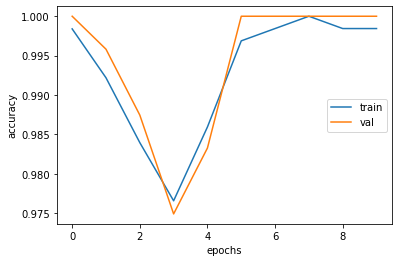

In [34]:
plt.plot(history_res101.history['accuracy'], label = 'train',)
plt.plot(history_res101.history['val_accuracy'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
image_shape = (512, 512, 3)
res101_model = ResNet101(include_top=False, pooling='avg', weights=None, input_shape = (image_shape))
for layer in res101_model.layers:
    layer.trainable = True

N_CLASSES = 2

model = Sequential()
model.add(res101_model)
model.add(Dropout(0.6))
model.add(Flatten())
model.add(BatchNormalization())
#model.add(Dense(300))
#model.add(BatchNormalization())
#model.add(Dense(100))
#model.add(BatchNormalization())
#model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

In [ ]:
# GCCT
# 다시 라벨별 분리하지 않은 데이터 경로에서 작업 (덕선선생님이 만드신것)
# test dataset 은 다시 라벨별로 분리해둔 폴더를 사용
# 1007 learning rate reduction 추가
from tensorflow.keras.callbacks import ReduceLROnPlateau

BATCH_SIZE = 32



GCCT_train_path = '/home/ncp/workspace/blocks1/kidneyData_windowing_mass/TRAIN/GCCT/'
GCCT_test_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass/TEST/GCCT/'

# y is imbalance - KFold 대신 StratifiedKFold 사용
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)

# create datagen
create_datagen = ImageDataGenerator(rescale= 1./255.)


# generate test data first
GCCT_test_generator = create_datagen.flow_from_directory(GCCT_test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (512, 512),
                                                   class_mode = 'categorical')


## PERFORM TRAIN & VAL ## - ART

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
val_acc = 0

fold_var = 1 # weight 나 모델 저장용

for train_index, val_index in skf.split(PRE_train_df, PRE_train_df['label']):  # Y의 분포 기준으로 나눔
    
    training_data = PRE_train_df.iloc[train_index]
    validation_data = PRE_train_df.iloc[val_index]
    
    train_data_generator = create_datagen.flow_from_dataframe(training_data, directory = GCCT_train_path, 
                                                             x_col = 'filename', y_col = 'label', 
                                                             class_mode = 'categorical', 
                                                             shuffle = True)
    valid_data_generator = create_datagen.flow_from_dataframe(validation_data, directory = GCCT_train_path, 
                                                             x_col = 'filename', y_col = 'label', 
                                                             class_mode = 'categorical', 
                                                             shuffle = True)
    
    optimizer = optimizers.Adam(learning_rate= 0.0001, decay= 1e-6)
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                           patience =3, 
                                           verbose =1,
                                            factor = 0.2,
                                            min_lr =0.0000001)
    model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    checkpointer = ModelCheckpoint(filepath='./2D_classification_ART-ResNet101_crossval.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
    early_stopping = EarlyStopping(verbose=1, patience=15)

    history_res101 = model.fit(train_data_generator,
                        steps_per_epoch = 20,
                        epochs = 100,
                        verbose = 1,
                        validation_data = valid_data_generator,
                        callbacks = [checkpointer, early_stopping, learning_rate_reduction])
    
    # validation accuracy, loss
    results = model.evaluate(valid_data_generator)
    results = dict(zip(model.metrics_names, results))
    
    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])
    
    tf.keras.backend.clear_session()
    
    fold_var += 1
    
    val_acc += results['accuracy'] / 10   # 평균 ACC
    
print("mean validation accuracy: ", val_acc)

In [ ]:
model_GCCT = model

result = model_GCCT.evaluate(GCCT_test_generator)

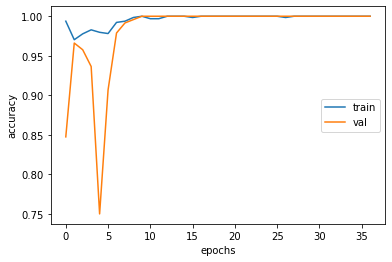

In [30]:


plt.plot(history_res101.history['accuracy'], label = 'train',)
plt.plot(history_res101.history['val_accuracy'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()



In [ ]:
path_resnet_PRE = '/home/ncp/workspace/blocks3/zio_code/cancer_configuration_PRE-ResNet101_crossval.hdf5'
PRE_resnet = tf.keras.models.load_model(path_resnet_PRE)

In [ ]:
image_shape = (512, 512, 3)
res101_model = ResNet101(include_top=False, pooling='avg', weights=None, input_shape = (image_shape))
for layer in res101_model.layers:
    layer.trainable = True

N_CLASSES = 2

model = Sequential()
model.add(res101_model)
model.add(Dropout(0.6))
model.add(Flatten())
model.add(BatchNormalization())
#model.add(Dense(300))
#model.add(BatchNormalization())
#model.add(Dense(100))
#model.add(BatchNormalization())
#model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

In [ ]:
# PRE
# 다시 라벨별 분리하지 않은 데이터 경로에서 작업 (덕선선생님이 만드신것)
# test dataset 은 다시 라벨별로 분리해둔 폴더를 사용
# 1007 learning rate reduction 추가
from tensorflow.keras.callbacks import ReduceLROnPlateau

BATCH_SIZE = 32

ART_train_path = '/home/ncp/workspace/blocks1/kidneyData_windowing_mass/TRAIN/ART/'
PRE_train_path = '/home/ncp/workspace/blocks1/kidneyData_windowing_mass/TRAIN/PRE/'
ART_test_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TEST/ART/'
PRE_test_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TEST/PRE/'

# y is imbalance - KFold 대신 StratifiedKFold 사용
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)

# create datagen
create_datagen = ImageDataGenerator(rescale= 1./255.)


# generate test data first
PRE_test_generator = create_datagen.flow_from_directory(PRE_test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (512, 512),
                                                   class_mode = 'categorical')


## PERFORM TRAIN & VAL ## - ART

VALIDATION_ACCURACY_PRE = []
VALIDATION_LOSS_PRE = []
val_acc_PRE = 0

fold_var = 1 # weight 나 모델 저장용

for train_index, val_index in skf.split(PRE_train_df, PRE_train_df['label']):  # Y의 분포 기준으로 나눔
    
    training_data = PRE_train_df.iloc[train_index]
    validation_data = PRE_train_df.iloc[val_index]
    
    train_data_generator = create_datagen.flow_from_dataframe(training_data, directory = PRE_train_path, 
                                                             x_col = 'filename', y_col = 'label', 
                                                             class_mode = 'categorical', 
                                                             shuffle = True)
    valid_data_generator = create_datagen.flow_from_dataframe(validation_data, directory = PRE_train_path, 
                                                             x_col = 'filename', y_col = 'label', 
                                                             class_mode = 'categorical', 
                                                             shuffle = True)
    
    optimizer = optimizers.Adam(learning_rate= 0.0001, decay= 1e-6)
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                           patience =3, 
                                           verbose =1,
                                            factor = 0.2,
                                            min_lr =0.0000001)
    model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    checkpointer = ModelCheckpoint(filepath='./2D_classification_PRE-ResNet101_crossval.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
    early_stopping = EarlyStopping(verbose=1, patience=15)

    history_res101_PRE = model.fit(train_data_generator,
                        steps_per_epoch = 20,
                        epochs = 100,
                        verbose = 1,
                        validation_data = valid_data_generator,
                        callbacks = [checkpointer, early_stopping])
    
    # validation accuracy, loss
    results_PRE = model.evaluate(valid_data_generator)
    results_PRE = dict(zip(model.metrics_names, results_PRE))
    
    VALIDATION_ACCURACY_PRE.append(results_PRE['accuracy'])
    VALIDATION_LOSS_PRE.append(results_PRE['loss'])
    
    tf.keras.backend.clear_session()
    
    fold_var += 1
    
    val_acc_PRE += results_PRE['accuracy'] / 10   # 평균 ACC
    
print("mean validation accuracy: ", val_acc_PRE)

In [ ]:
model_pre = model 
result = model_pre.evaluate(PRE_test_generator)

In [46]:
history_res101_PRE.history

{'loss': [0.05856511369347572],
 'accuracy': [0.9825119376182556],
 'val_loss': [0.003313901135697961],
 'val_accuracy': [1.0]}

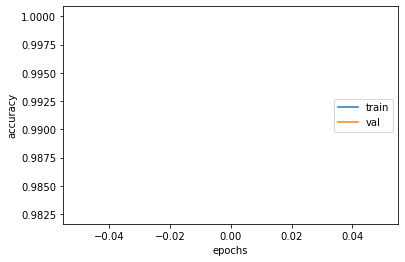

In [44]:
plt.plot(history_res101_PRE.history['accuracy'], label = 'train',)
plt.plot(history_res101_PRE.history['val_accuracy'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
path_resnet_PRE = '/home/ncp/workspace/blocks3/zio_code/cancer_configuration_PRE-ResNet101_crossval.hdf5'
PRE_resnet = tf.keras.models.load_model(path_resnet_PRE)

In [ ]:
PRE_resnet()

In [ ]:
result_PRE = model.evaluate(PRE_test_generator)

In [ ]:
plt.plot(history_res101_PRE.history['accuracy'], label = 'train',)
plt.plot(history_res101_PRE.history['val_accuracy'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
!nvidia-smi